## Calculate hourly reference ET 

In [1]:
%pylab inline
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
sns.set_style('whitegrid', {'grid.linestyle': u'--'})
matplotlib.rc('pdf', fonttype=42)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import dwd

In [4]:
# read weather data
weather = pd.read_csv('Carlsfeld_dwd.csv', index_col=0)
weather.index = pd.to_datetime(weather.index)
weather.dropna().head(5)

T  Tmin  Tmax  Prec  Rad  RHmin  RHmax   u2      aP
1995-09-01 00:00:00  5.9   5.9   5.9   3.5  0.0   98.0   98.0  5.1  1010.3
1995-09-01 01:00:00  6.0   6.0   6.0   3.0  0.0   98.0   98.0  5.3  1009.2
1995-09-01 02:00:00  6.1   6.1   6.1   4.6  0.0   98.0   98.0  5.5  1008.3
1995-09-01 03:00:00  6.3   6.3   6.3   5.1  0.0   98.0   98.0  5.5  1007.7
1995-09-01 19:00:00  8.4   8.4   8.4   4.2  0.0  100.0  100.0  4.2  1008.1

In [5]:
def daylight(datex,loci=(50.424, 12.597)):
    #calculate hourly daylight distribution from date and location
    #datex :: datetime
    #loci :: tuple of lat lon
    #returns :: hourly share of daylight as np.array
    
    from astral import LocationInfo
    from astral.sun import sun

    sx = np.zeros(240)
    s = sun(LocationInfo(loci[0], loci[1]).observer, datex)
    s1 = int(s["sunrise"].hour*10+s["sunrise"].minute/6.)
    s2 = int(s["sunset"].hour*10+s["sunset"].minute/6.)
    sk = np.sin(np.arange(0,np.pi,np.pi/(s2-s1)))
    sx[s1:s1+len(sk)] = sk
    sx /= np.sum(sx)
    
    return np.sum(np.reshape(sx, (24, 10)), axis=1)
    
daylight(pd.to_datetime('2022-10-01'))

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01641355, 0.05166701, 0.08315394, 0.10857895,
       0.12608855, 0.1344063 , 0.13292583, 0.12175506, 0.10170834,
       0.07424709, 0.04137322, 0.00768218, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [6]:
from astral import LocationInfo
from astral.sun import sun
datex = pd.to_datetime('2022-06-21')
loci=(50.424, 12.597)
#sun(LocationInfo(loci[0], loci[1]).observer, datex)

sx = np.zeros(240)
s = sun(LocationInfo(loci[0], loci[1]).observer, datex)
s1 = int(s["sunrise"].hour*10+s["sunrise"].minute/6.)
s2 = int(s["sunset"].hour*10+s["sunset"].minute/6.)
sk = np.sin(np.arange(0,np.pi,np.pi/(s2-s1)))
sx[s1:s1+len(sk)] = sk
sx /= np.sum(sx)

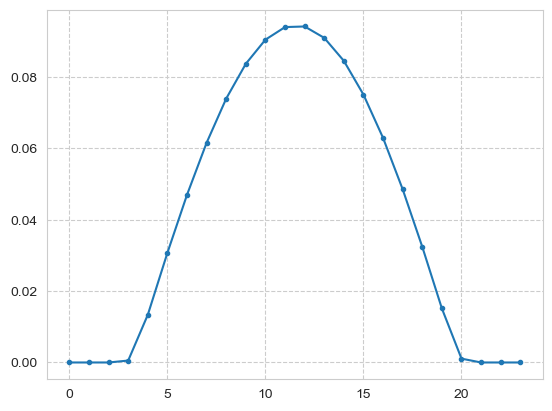

In [19]:
plot(np.sum(np.reshape(sx, (24, 10)), axis=1),'.-')

In [7]:
# aggregate daily time series of weather
weather1D = weather.resample('1D').agg({'T': 'mean', 'Tmin': 'min', 'Tmax': 'max', 'Prec': 'sum', 'Rad': 'sum', 'RHmin': 'min', 'RHmax': 'max','u2': 'mean', 'aP':'mean'})

# calculate daily ET
ET0SJ, ET0PM, ET0PT = dwd.ET_SzilagyiJozsa(weather1D,Elev = 900., lat = 50.42)
dummyk = pd.concat([ET0SJ, ET0PM, ET0PT],axis=1)
dummyk.columns = ['ET0SJ', 'ET0PM', 'ET0PT']
weather1D = pd.concat([weather1D,dummyk],axis=1)

<AxesSubplot:>

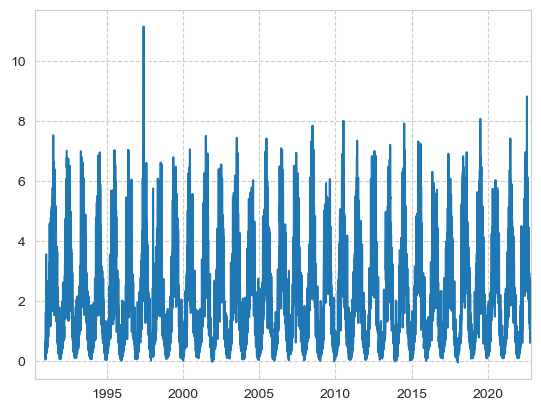

In [8]:
weather1D.ET0PM.plot()

In [9]:
# attribute HOURLY ET from daily calculations to timeseries
weather['ETo'] = np.nan

for i in weather1D.index:
    weather.loc[i:i+pd.Timedelta('23h'),'ETo'] = weather1D.loc[i,'ET0PM'] * daylight(i)

<AxesSubplot:>

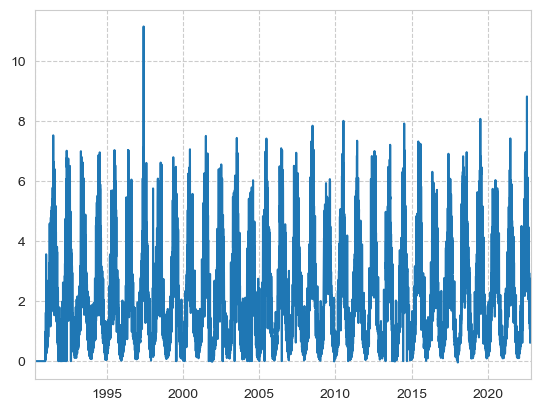

In [10]:
#weather['ETo'].plot()
weather['ETo'].resample('1D').sum().plot()

In [57]:
weather.to_csv('Carlsfeld_dwd_wET.csv')

## Water Balance

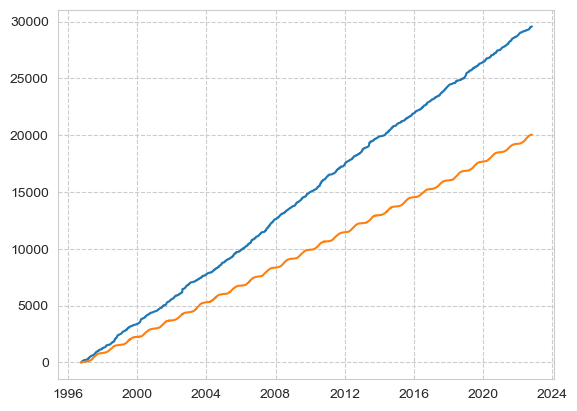

In [11]:
plot(weather.loc[pd.to_datetime('1996-10-01'):pd.to_datetime('2022-12-01'),'Prec'].cumsum())
plot(weather.loc[pd.to_datetime('1996-10-01'):pd.to_datetime('2022-12-01'),'ETo'].cumsum())

<AxesSubplot:>

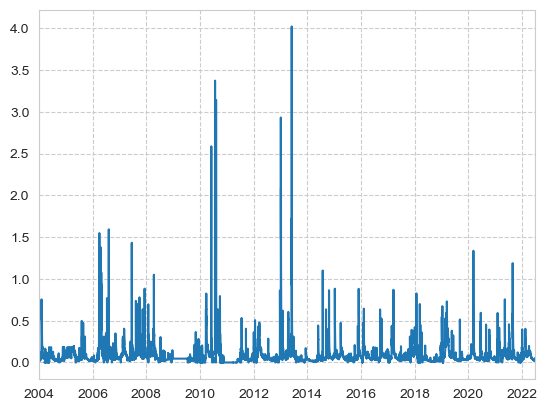

In [13]:
#KleineBockau = pd.read_excel('Durchfluss_LTV_Kleine_Bockau.xlsx', index_col=0)
#KleineBockau.index = pd.to_datetime(KleineBockau.Datum.astype(str)+' '+KleineBockau.Zeit.astype(str))
KleineBockau.Durchfluss_Kleine_Bockau.resample('1H').mean()*3600/(A_KleineBockau/1000)

In [18]:
A_BachOst = 544248 #area in m2
A_Wilzsch = 1828188 #area in m2
A_KleineBockau = 4677580 #area in m2

Q_BachOst = pd.read_excel('Durchfluss_LTV_Bach_Ost.xlsx', index_col=0)
Q_BachOst.index = pd.to_datetime(Q_BachOst.Datum.astype(str)+' '+Q_BachOst.Zeit.astype(str))
#Q_BachOst.Durchfluss_Bach_OSt.resample('1H').mean().plot()

Wilzsch = pd.read_excel('Durchfluss_Wilzsch_Stündlich_2011-2021.xlsx', index_col=0)
#(Wilzsch.Durchfluss.resample('1H').mean()*3600/1828.188).cumsum().plot()
#(Q_BachOst.Durchfluss_Bach_OSt.resample('1H').mean()*3600/544248).cumsum().plot()

KleineBockau = pd.read_excel('Durchfluss_LTV_Kleine_Bockau.xlsx', index_col=0)
KleineBockau.index = pd.to_datetime(KleineBockau.Datum.astype(str)+' '+KleineBockau.Zeit.astype(str))

qh = pd.concat([Wilzsch.Durchfluss.resample('1H').mean()*3600/(A_Wilzsch/1000),Q_BachOst.Durchfluss_Bach_OSt.resample('1H').mean()*3600/A_BachOst,KleineBockau.Durchfluss_Kleine_Bockau['2011-01-01':].resample('1H').mean()*3600/(A_KleineBockau/1000)],axis=1)
qh.columns = ['Wilzsch', 'BachOst', 'KleineBockau']

<AxesSubplot:>

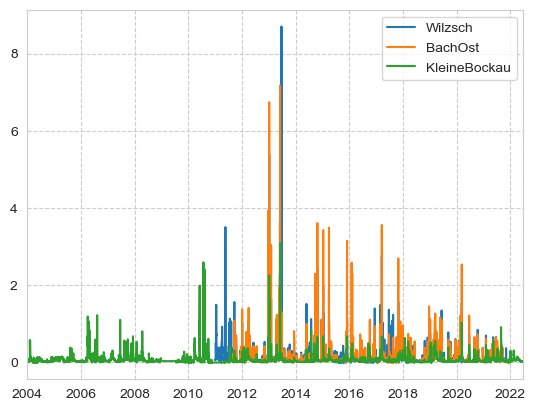

In [15]:
qh.plot()

<AxesSubplot:>

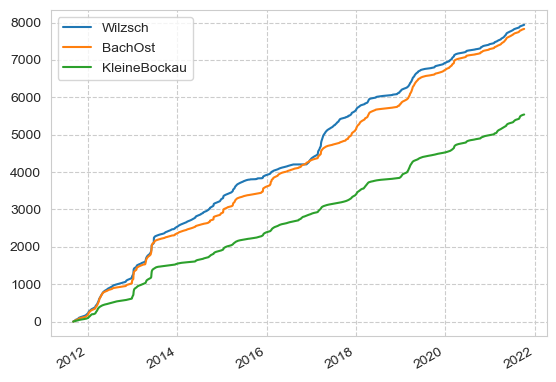

In [19]:
qh.dropna().cumsum().plot()


<AxesSubplot:>

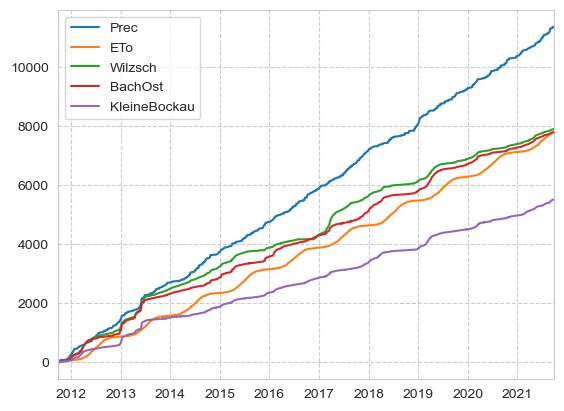

In [21]:
WB_carlsfeld = pd.concat([weather.loc[pd.to_datetime('2011-10-01'):pd.to_datetime('2021-09-30 23:00'),['Prec','ETo','T']], qh.loc[pd.to_datetime('2011-10-01'):pd.to_datetime('2021-09-30 23:00')]], axis=1)
WB_carlsfeld[['Prec','ETo','Wilzsch','BachOst','KleineBockau']].cumsum().plot()

In [22]:
WB_carlsfeld.to_csv('WBcarlsfeld.csv')
WB_carlsfeld1D = WB_carlsfeld.resample('1D').agg({'Prec': 'sum','ETo': 'sum','T': 'mean','Wilzsch': 'sum','BachOst': 'sum','KleineBockau': 'sum'})
WB_carlsfeld1D.to_csv('WBcarlsfeld1D.csv')

In [23]:
import spotpy
import pyGR4J as pG

In [24]:
params = [5.40757648942523E+002,-4.80310910679438E-002,4.60127227314395E+000,3.36467040247373E+000,0.9]

#set weights of lag function
w1 = pG.tWeightsL1(params[3])
w2 = pG.tWeightsL2(params[3])

Qsim = pG.pyGR4J(WB_carlsfeld1D[['Prec','ETo','Wilzsch']].values,params,w1,w2)
Qsim = pd.Series(Qsim,index=WB_carlsfeld1D.index)
Qsim.name = 'Simulation'

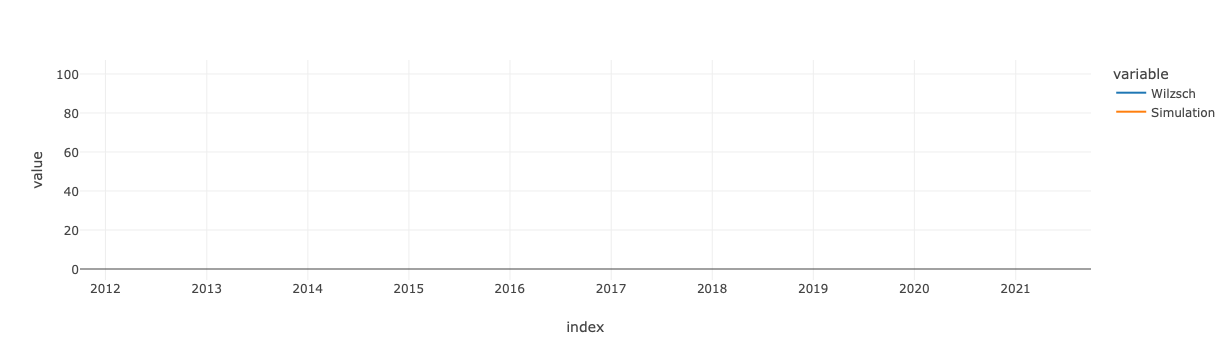

In [25]:
px.line(pd.concat([WB_carlsfeld1D.Wilzsch,Qsim],axis=1), template='none')

In [26]:
class spotpy_setup(object):
    def __init__(self):
        self.params = [spotpy.parameter.Uniform('SMA',low=100.0 , high=800.,  optguess=2.40757648942523E+002),   #Capacity of the production soil (SMA) store (mm)
                       spotpy.parameter.Uniform('Wex',low=-0.01 , high=-0.0001,  optguess=-4.80310910679438E-003),#Water exchange coefficient (mm)
                       spotpy.parameter.Uniform('CapR',low=2.0 , high=6., optguess=4.60127227314395E+000), #Capacity of the routing store (mm)
                       spotpy.parameter.Uniform('Ti',low=1.5 , high=7.5, optguess=3.36467040247373E+000), #Time parameter (days) for unit hydrographs
                       spotpy.parameter.Uniform('Spl',low=0.5 , high=0.99, optguess=0.9)
                       ]
        self.evals = WB_carlsfeld1D.Wilzsch.values
        
    def parameters(self):
        return spotpy.parameter.generate(self.params)
    
    def simulation(self,x):
        #set weights of lag function
        w1 = pG.tWeightsL1(x[3])
        w2 = pG.tWeightsL2(x[3])

        qsim = pG.pyGR4J(WB_carlsfeld1D[['Prec','ETo','Wilzsch']].values,x,w1,w2)
        return qsim
    
    def evaluation(self):
        return self.evals
    
    def objectivefunction(self,simulation,evaluation, params=None):
        #try:
        #    like = spotpy.objectivefunctions.kge_non_parametric(evaluation,simulation) 
        #except:
        import hydroeval as he
        like = he.kge(simulation[40:],evaluation[40:])[0][0] #allow for 40 days spin-up
        return like

spot_setup=spotpy_setup()

In [27]:
#test
x = spot_setup.parameters()['random']
simulation = spot_setup.simulation(x)
spot_setup.objectivefunction(simulation,spot_setup.evaluation())

-0.23764241078620985

In [ ]:
dbname = 'pyGR4J_Wilzsch'
rep = 100000
dream_sampler = spotpy.algorithms.dream(spot_setup, dbname='DREAM_'+dbname, dbformat='csv')
dream_sampler.sample(rep, nChains=10, convergence_limit=0.05, runs_after_convergence=200)


Initializing the  DiffeRential Evolution Adaptive Metropolis (DREAM) algorithm  with  100000  repetitions
The objective function will be maximized
Starting the DREAM algotrithm with 100000 repetitions...
Initialize  10  chain(s)...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'DREAM_pyGR4J_Wilzsch.csv' created.
5 of 100000, maximal objective function=0.16388, time remaining: 09:22:37
Beginn of Random Walk
13 of 100000, maximal objective function=0.16388, time remaining: 08:03:02


//Users/cojack/anaconda3/lib/python3.9/site-packages/spotpy/algorithms/dream.py:111: RuntimeWarning:

divide by zero encountered in double_scalars



21 of 100000, maximal objective function=0.16388, time remaining: 07:44:16
29 of 100000, maximal objective function=0.16388, time remaining: 07:41:25
Acceptance rates [%] =100. 100. 100. 100. 100. 100. 100. 100. 100.  50.
Convergence rates =1.8374 1.7855 1.6793 2.6599 2.0321
38 of 100000, maximal objective function=0.16388, time remaining: 07:31:57
Acceptance rates [%] =100.   100.   100.   100.   100.   100.   100.   100.   100.    66.67
Convergence rates =3.4777 1.4268 2.4542 2.2245 1.6863
46 of 100000, maximal objective function=0.16388, time remaining: 07:26:28
Acceptance rates [%] =100. 100. 100. 100. 100.  75. 100. 100. 100.  75.
Convergence rates =1.8944 1.4072 1.8862 2.0492 1.6772
54 of 100000, maximal objective function=0.16388, time remaining: 07:22:56
Acceptance rates [%] =100. 100. 100. 100.  80.  80. 100. 100. 100.  80.
Convergence rates =2.0982 2.2529 2.1111 1.6713 2.0947
62 of 100000, maximal objective function=0.16388, time remaining: 07:20:05
69 of 100000, maximal obje

In [ ]:
import hydroeval as he
from scipy.stats import spearmanr
from scipy.stats import linregress
dbname = 'pyGR4J_Wilzsch'

evalx = WB_carlsfeld1D.Wilzsch
results = spotpy.analyser.load_csv_results('DREAM_'+dbname)
# Get fields with simulation data
fields = [word for word in results.dtype.names if word.startswith('sim')]
resDF = pd.DataFrame(results)
def eval2(x, y):
    return pd.Series(np.concatenate((linregress(x, y)[:], spearmanr(x, y)[:])),
                     index=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'spearman_corr', 'spearman_p'])
cidx = np.where(resDF.columns.str.contains("simulat"))[0]
resDF['KGE'] = np.nan
resDF['spearman_corr'] = np.nan
resDF['R2'] = np.nan

for i in resDF.index:
    resDF.loc[i, 'spearman_corr'] = eval2(evalx.values, resDF.iloc[i, cidx].values)[-2]
    resDF.loc[i, 'R2'] = eval2(evalx.values, resDF.iloc[i, cidx].values)[-3] ** 2
    resDF.loc[i, 'KGE'] = he.kge(resDF.iloc[i, cidx].values, evalx.values)[0][0]

In [ ]:
subplot(211)
fill_between(eval.index[90:], (resDF.iloc[:, cidx].min()[90:]), (resDF.iloc[:, cidx].max()[90:]), alpha=0.2,label='parameter space')

plot(eval.index[90:], (eval.values[90:]), label='Observation')
#plot(eval.index[90:], (resDF.iloc[resDF['like1'].idxmax(), cidx].values[90:]), label='max like')
plot(eval.index[90:], (resDF.iloc[resDF['KGE'].idxmax(), cidx].values[90:]), label='max KGE')

legend(ncol=3)
ylim(0,11)
ylabel('Q (mm/day)')
tick_params(labelbottom=False)

subplot(212)
fill_between(eval.index[90:], np.cumsum(resDF.iloc[:, cidx].min()[90:]), np.cumsum(resDF.iloc[:, cidx].max()[90:]), alpha=0.2,label='parameter space')

plot(eval.index[90:], np.cumsum(eval.values[90:]), label='Observation')
#plot(eval.index[90:], np.cumsum(resDF.iloc[resDF['like1'].idxmax(), cidx].values[90:]), label='max like')
plot(eval.index[90:], np.cumsum(resDF.iloc[resDF['KGE'].idxmax(), cidx].values[90:]), label='max KGE')

ylim(0,1000)
ylabel('$\sum$Q (mm/day)')